In [365]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from selenium.common.exceptions import TimeoutException
import threading
import matplotlib.pyplot as plt
from sklearn import preprocessing
import statsmodels.api as sm
import seaborn as sns
import regex as re
import csv
import pandas as pd
import numpy as np

In [2]:
# scrape book data using threads and Selenium
class bookScraper(threading.Thread):

    def __init__(self, start_page, end_page):
        threading.Thread.__init__(self)
        self.start_page = start_page
        self.end_page = end_page
        self.bookData = []
        self.bookUrls = []
        self.driver = webdriver.Chrome()

    def run(self):
        self.scrape_books()
        self.saveToCSV(f"Goodreads_Data_{self.start_page}_{self.end_page}.csv")
        self.close()   

    def login(self, username, password):
        wait = WebDriverWait(self.driver, 10)
        login_link = wait.until(EC.element_to_be_clickable((By.XPATH, '//a[@class="siteHeader__topLevelLink" and contains(text(), "Sign In")]')))
        login_link.click()

        button_email = self.driver.find_element(By.XPATH, '//*[@id="choices"]/div/a[2]/button')
        button_email.click()

        email_input = self.driver.find_element(By.XPATH, '//input[@id="ap_email"]')
        email_input.send_keys(username)
        
        password_input = self.driver.find_element(By.XPATH, '//input[@id="ap_password"]')
        password_input.send_keys(password)
        
        submit_button = self.driver.find_element(By.XPATH, '//input[@id="signInSubmit"]')
        submit_button.click()

    def scrape_books(self):
        for page in range(self.start_page, self.end_page + 1):
            self.driver.get(f"https://www.goodreads.com/list/show/1.Best_Books_Ever?page={page}")
            if page == self.start_page:
                self.login('misia.kwolik@yahoo.com', 'PAD123')
            self.getBookURLs()
        self.getBookDetails()

    def getBookURLs(self):
        
        book_elements = self.driver.find_elements(By.XPATH, '//a[@class="bookTitle"]')
        for element in book_elements:
            url = element.get_attribute('href')
            if url not in self.bookUrls:
                self.bookUrls.append(url)
            
    def getBookDetails(self):
        for url in self.bookUrls:
            self.driver.get(url)
            try:
                wait = WebDriverWait(self.driver, 20)
                # scraping the title, author, year, rating, number of ratings, number of pages, genres
                title = wait.until(EC.presence_of_element_located((By.XPATH, '//h1[@data-testid="bookTitle"]'))).text
                author = self.driver.find_element(By.XPATH, '//span[@class="ContributorLink__name"]').text
                year = self.driver.find_element(By.XPATH, '//p[@data-testid="publicationInfo"]').text
                rating = self.driver.find_element(By.XPATH, '//div[@class="RatingStatistics__rating"]').text
                rating_amount = self.driver.find_element(By.XPATH, '//span[@data-testid="ratingsCount"]').text
                page_num = self.driver.find_element(By.XPATH, '//p[@data-testid="pagesFormat"]').text
                genre_elements = self.driver.find_elements(By.XPATH, '//span[@class="BookPageMetadataSection__genreButton"]/a/span[@class="Button__labelItem"]')
                genres = [genre_element.text for genre_element in genre_elements]

                self.bookData.append([title, author, year, rating, rating_amount, page_num, genres])

            except TimeoutException:
                print(f"TimeoutException: Failed to retrieve book details for URL: {url}")
                
            # return to main page
            self.driver.back()
            
    def saveToCSV(self, filename):
        with open(filename, 'w', newline='', encoding='utf-8') as file:
            writer = csv.writer(file)
            writer.writerow(['Title', 'Author', 'Year', 'Rating', 'Number of Ratings', 'Number of Pages', 'Genres'])
            writer.writerows(self.bookData)

    def close(self):
        self.driver.quit()

In [ ]:
# thread list
threads = []

# number of threads
num_threads = 3

pages_per_thread = 20
start_pages = [1, 21, 41]
end_pages = [20, 40, 60]

for i in range(num_threads):
    thread = bookScraper(start_pages[i], end_pages[i])
    threads.append(thread)
    thread.start()
    
for thread in threads:
    thread.join()
    
# combining data
combined_book_data = []
for thread in threads:
    combined_book_data.extend(thread.bookData)

combined_filename = "Combined_Goodreads_Data.csv"
threads[0].saveToCSV(combined_filename)

# Data Cleaning

## Reading csv file

In [630]:
df = pd.read_csv('All_Goodreads_Data.csv')
df.head(20)

,Title,Author,Year,Rating,Number of Ratings,Number of Pages,Genres
0,The Hunger Games,Suzanne Collins,"First published September 14, 2008",4.33,"8,023,476 ratings","374 pages, Hardcover","['Young Adult', 'Fiction', 'Dystopia', 'Fantas..."
1,Harry Potter and the Order of the Phoenix,J.K. Rowling,"First published June 21, 2003",4.50,"3,168,262 ratings","912 pages, Paperback","['Fantasy', 'Young Adult', 'Fiction', 'Magic',..."
2,Pride and Prejudice,Jane Austen,"First published January 28, 1813",4.28,"3,972,316 ratings","279 pages, Paperback","['Classics', 'Literature', 'Historical', 'Audi..."
3,To Kill a Mockingbird,Harper Lee,"First published January 1, 1960",4.27,"5,729,805 ratings","323 pages, Paperback","['Classics', 'Fiction', 'Historical Fiction', ..."
4,The Book Thief,Markus Zusak,"First published March 1, 2006",4.39,"2,382,262 ratings","552 pages, Hardcover","['Historical Fiction', 'Fiction', 'Young Adult..."
5,Twilight,Stephenie Meyer,"First published October 5, 2005",3.64,"6,193,142 ratings","498 pages, Paperback","['Fantasy', 'Young Adult', 'Romance', 'Fiction..."
6,Animal Farm,George Orwell,"First published August 17, 1945",3.98,"3,603,986 ratings","128 pages, Mass Market Paperback","['Classics', 'Fiction', 'Dystopia', 'Fantasy',..."
7,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,J.R.R. Tolkien,"First published October 20, 1955",4.61,"127,866 ratings","1728 pages, Mass Market Paperback","['Fantasy', 'Fiction', 'Classics', 'Adventure'..."
8,The Chronicles of Narnia,C.S. Lewis,"First published January 1, 1956",4.27,"620,082 ratings","767 pages, Paperback","['Fantasy', 'Classics', 'Young Adult', 'Childr..."
9,The Fault in Our Stars,John Green,"First published January 10, 2012",4.15,"4,798,647 ratings","313 pages, Hardcover","['Young Adult', 'Romance', 'Fiction', 'Contemp..."


## Data type information

In [260]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5617 entries, 0 to 5616
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Title              5617 non-null   object 
 1   Author             5617 non-null   object 
 2   Year               5617 non-null   object 
 3   Rating             5617 non-null   float64
 4   Number of Ratings  5617 non-null   object 
 5   Number of Pages    5617 non-null   object 
 6   Genres             5617 non-null   object 
dtypes: float64(1), object(6)
memory usage: 307.3+ KB


(5617, 7)

## Finding and eliminating duplicates

In [261]:
print(df.duplicated().any())

True


In [262]:
df = df.drop_duplicates()
df.shape

(5589, 7)

## 'Year' Column

In [263]:
# leaving 3 and 4 digit numbers
df['Year'] = df['Year'].str.extract(r'(\d{3,4})')
df.head()

,Title,Author,Year,Rating,Number of Ratings,Number of Pages,Genres
0,The Hunger Games,Suzanne Collins,2008,4.33,"8,023,476 ratings","374 pages, Hardcover","['Young Adult', 'Fiction', 'Dystopia', 'Fantas..."
1,Harry Potter and the Order of the Phoenix,J.K. Rowling,2003,4.50,"3,168,262 ratings","912 pages, Paperback","['Fantasy', 'Young Adult', 'Fiction', 'Magic',..."
2,Pride and Prejudice,Jane Austen,1813,4.28,"3,972,316 ratings","279 pages, Paperback","['Classics', 'Literature', 'Historical', 'Audi..."
3,To Kill a Mockingbird,Harper Lee,1960,4.27,"5,729,805 ratings","323 pages, Paperback","['Classics', 'Fiction', 'Historical Fiction', ..."
4,The Book Thief,Markus Zusak,2006,4.39,"2,382,262 ratings","552 pages, Hardcover","['Historical Fiction', 'Fiction', 'Young Adult..."


## 'Number of Ratings' Column

In [264]:
# eliminating commas and leaving digits
df['Number of Ratings'] = df['Number of Ratings'].str.replace(',', '')
df['Number of Ratings'] = df['Number of Ratings'].str.strip().str.replace(r'\D+', '')

df['Number of Ratings'] = df['Number of Ratings'].astype(int)
df.head()

/var/folders/9x/yx1lb15s25v5pjcj6fv0mdrc0000gn/T/ipykernel_14038/2095238569.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Number of Ratings'] = df['Number of Ratings'].str.strip().str.replace(r'\D+', '')


,Title,Author,Year,Rating,Number of Ratings,Number of Pages,Genres
0,The Hunger Games,Suzanne Collins,2008,4.33,8023476,"374 pages, Hardcover","['Young Adult', 'Fiction', 'Dystopia', 'Fantas..."
1,Harry Potter and the Order of the Phoenix,J.K. Rowling,2003,4.50,3168262,"912 pages, Paperback","['Fantasy', 'Young Adult', 'Fiction', 'Magic',..."
2,Pride and Prejudice,Jane Austen,1813,4.28,3972316,"279 pages, Paperback","['Classics', 'Literature', 'Historical', 'Audi..."
3,To Kill a Mockingbird,Harper Lee,1960,4.27,5729805,"323 pages, Paperback","['Classics', 'Fiction', 'Historical Fiction', ..."
4,The Book Thief,Markus Zusak,2006,4.39,2382262,"552 pages, Hardcover","['Historical Fiction', 'Fiction', 'Young Adult..."


## 'Number of Pages' Column

In [265]:
# leaving digits and replacing empty records with '0'
df['Number of Pages'] = df['Number of Pages'].str.replace(r'\D', '')
df['Number of Pages'] = df['Number of Pages'].replace('', '0')

df['Number of Pages'] = df['Number of Pages'].astype(int)

/var/folders/9x/yx1lb15s25v5pjcj6fv0mdrc0000gn/T/ipykernel_14038/765018119.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Number of Pages'] = df['Number of Pages'].str.replace(r'\D', '')


## Other empty records

In [266]:
empty_values = df.isna().sum()
print(empty_values)

Title                0
Author               0
Year                 5
Rating               0
Number of Ratings    0
Number of Pages      0
Genres               0
dtype: int64


In [270]:
zero_pages = df[df['Number of Pages'] == 0]
print(zero_pages)

Empty DataFrame
Columns: [Title, Author, Year, Rating, Number of Ratings, Number of Pages, Genres]
Index: []


In [269]:
# eliminating records where 'Year' column is empty or 'Number of Pages' = 0
df = df.dropna(subset=['Year'])  
df = df[df['Number of Pages'] != 0]

df['Year'] = df['Year'].astype(int)

In [271]:
# duplicates in authors or titles
duplicate_titles_authors = df[df.duplicated(['Title', 'Author'])]
duplicate_titles_authors.shape

# sorting from highest number of ratings and leaving that duplicate with a higher number
df = df.sort_values('Number of Ratings', ascending=False)
mask = df.duplicated(subset=['Title'], keep='first')
df = df[~mask]

df = df.reset_index(drop=True)

In [274]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5242 entries, 0 to 5241
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Title              5242 non-null   object 
 1   Author             5242 non-null   object 
 2   Year               5242 non-null   int64  
 3   Rating             5242 non-null   float64
 4   Number of Ratings  5242 non-null   int64  
 5   Number of Pages    5242 non-null   int64  
 6   Genres             5242 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 286.8+ KB


## 'Genres' Column

In [311]:
# changing each genre row to list 
df['Genres'] = df['Genres'].apply(eval)

# counting values
exploded_genres = df['Genres'].explode().value_counts()
unique_genres = exploded_genres.index.tolist()

empty_genre_rows = df[df['Genres'].apply(lambda x: len(x) == 0)]
print(empty_genre_rows)

In [339]:
df = df.drop(df[df['Genres'].apply(lambda x: len(x) == 0)].index)

## Other titles

In [275]:
pattern = r'[^a-zA-Z0-9\s\W_]'
filtered_df = df[df['Title'].str.contains(pattern, regex=True, na=False)]
filtered_titles = filtered_df['Title'].tolist()

print(filtered_titles)

['Les Misérables', "Maus I: Un Survivant Raconte: Mon Père Saigne L'histoire", 'The 7½ Deaths of Evelyn Hardcastle', 'Shōgun', "La Vérité sur l'Affaire Harry Quebert", 'Déjà Dead', 'My Ántonia', 'Smaragdgrün', 'The Children of Húrin', 'Galápagos', 'Suite Française', 'El túnel', 'القرآن الكريم', 'الفيل الأزرق', 'الأسود يليق بك', 'Pedro Páramo', 'شجرتي شجرة البرتقال الرائعة', 'ساق البامبو', 'Père Goriot', 'هيبتا', 'تراب الماس', 'في قلبي أنثى عبرية', 'Kürk Mantolu Madonna', 'يوتوبيا', 'أحببتك أكثر مما ينبغي', 'عزازيل', 'Gödel, Escher, Bach: An Eternal Golden Braid', 'La Dame aux Camélias', 'ثلاثية غرناطة', 'Das erste Buch der Träume', 'Bilinmeyen Bir Kadının Mektubu', 'Travesuras de la niña mala', 'Unfinished Tales of Númenor and Middle-Earth', "L'Écume des jours", 'حوار مع صديقي الملحد', 'لا تحزن', 'Thérèse Raquin', 'com نسيان', 'Memórias Póstumas de Brás Cubas', 'أولاد حارتنا', 'La Mécanique du cœur', 'الطنطورية', 'ذاكرة الجسد', 'رحلتي من الشك إلى الإيمان', 'Capitães da Areia', 'The 13½

In [276]:
pattern = r'[\u0600-\u06FF]+'
filtered_df = df[df['Title'].str.contains(pattern, regex=True, na=False)]
filtered_titles = filtered_df['Title'].tolist()
df = df[~df['Title'].isin(filtered_titles)]

# Data Exploration and Visualisation

## Visualisation to find other empty records

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0.5, 0, 'Title'),
  Text(1.5, 0, 'Author'),
  Text(2.5, 0, 'Year'),
  Text(3.5, 0, 'Rating'),
  Text(4.5, 0, 'Number of Ratings'),
  Text(5.5, 0, 'Number of Pages'),
  Text(6.5, 0, 'Genres'),
  Text(7.5, 0, 'Author_Encoded')])

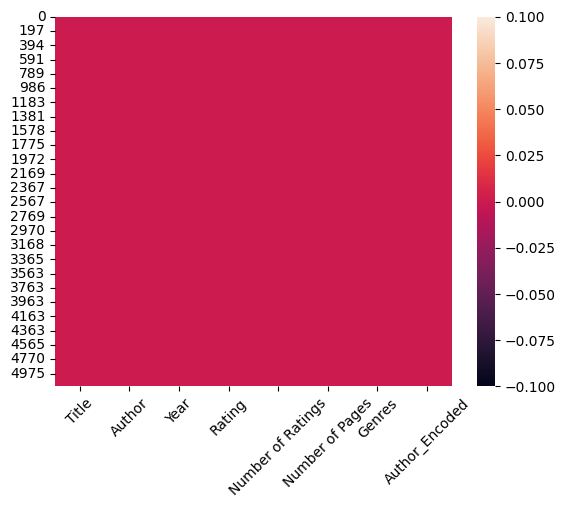

In [366]:
sns.heatmap(df.isnull())
plt.xticks(rotation=45)

/var/folders/9x/yx1lb15s25v5pjcj6fv0mdrc0000gn/T/ipykernel_14038/1517229988.py:1: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




Text(0, 0.5, 'Frequency')

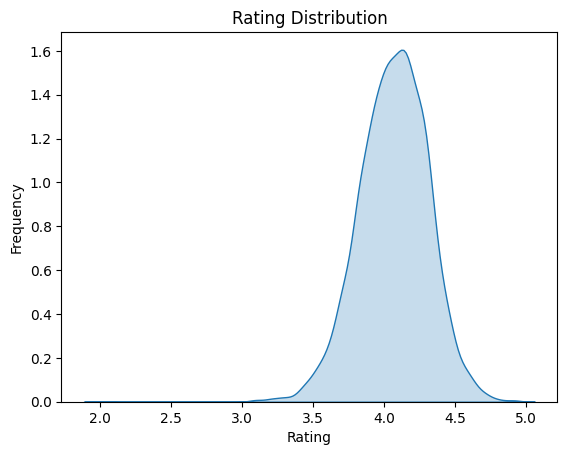

In [463]:
sns.kdeplot(df['Rating'], shade = True)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')

/var/folders/9x/yx1lb15s25v5pjcj6fv0mdrc0000gn/T/ipykernel_14038/805625907.py:1: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




Text(0, 0.5, 'Frequency')

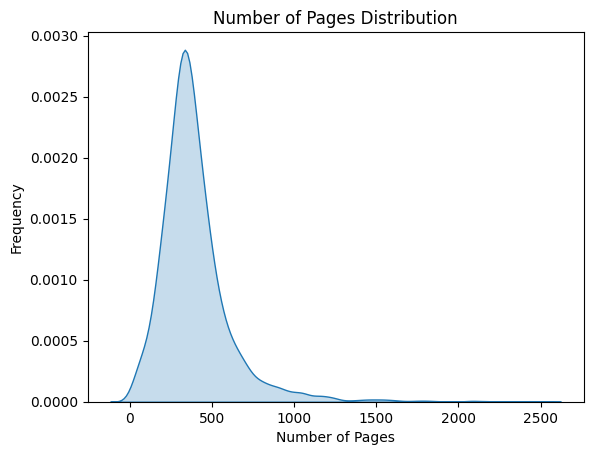

In [462]:
sns.kdeplot(df['Number of Pages'], shade = True)
plt.title('Number of Pages Distribution')
plt.xlabel('Number of Pages')
plt.ylabel('Frequency')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, '3.9'),
  Text(1, 0, '3.92'),
  Text(2, 0, '3.96'),
  Text(3, 0, '3.99'),
  Text(4, 0, '4.01'),
  Text(5, 0, '4.02'),
  Text(6, 0, '4.03'),
  Text(7, 0, '4.06'),
  Text(8, 0, '4.08'),
  Text(9, 0, '4.09'),
  Text(10, 0, '4.12'),
  Text(11, 0, '4.14'),
  Text(12, 0, '4.15'),
  Text(13, 0, '4.16'),
  Text(14, 0, '4.18'),
  Text(15, 0, '4.19'),
  Text(16, 0, '4.2'),
  Text(17, 0, '4.25'),
  Text(18, 0, '4.26'),
  Text(19, 0, '4.29')])

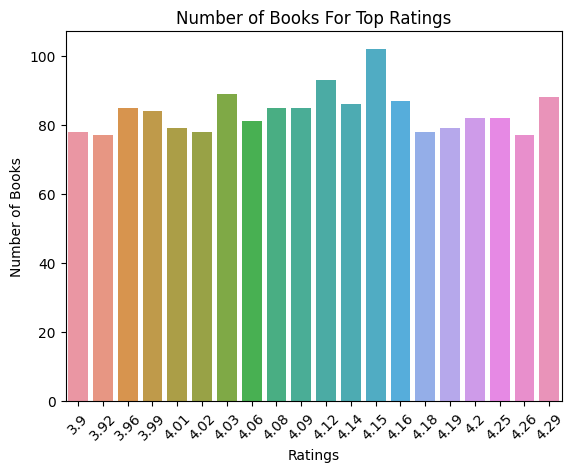

In [464]:
rating_counts = df['Rating'].value_counts().head(20)

books_per_rating = plt.figure()
sns.barplot(x = rating_counts.index, y = rating_counts.values)
plt.title('Number of Books For Top Ratings')
plt.xlabel('Ratings')
plt.ylabel('Number of Books')
plt.xticks(rotation = 45)

In [281]:
pd.options.display.float_format = "{:,.2f}".format
df.describe()

,Year,Rating,Number of Ratings,Number of Pages
count,"5,204.00","5,204.00","5,204.00","5,204.00"
mean,"1,977.80",4.07,"163,753.01",402.96
std,127.25,0.27,"400,399.23",317.35
min,180.00,0.00,0.00,2.00
25%,"1,984.00",3.91,"25,429.75",268.00
50%,"2,005.00",4.08,"59,960.50",352.00
75%,"2,012.00",4.24,"143,641.50",463.00
max,"2,023.00",5.00,"9,342,791.00","8,245.00"


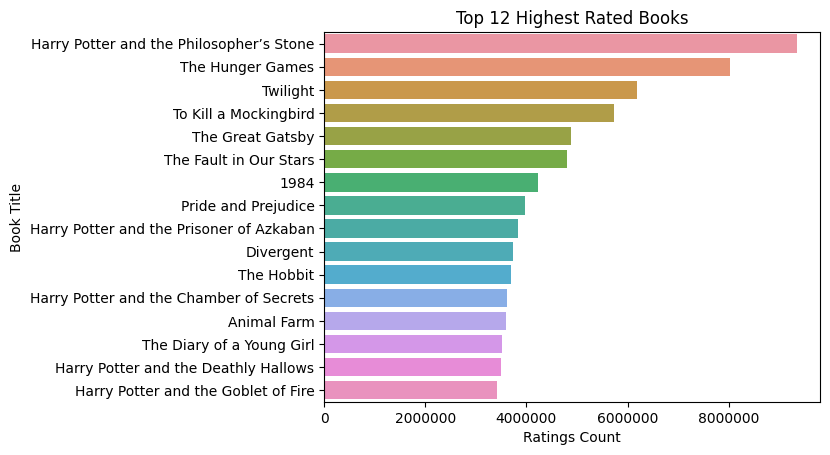

In [282]:
popular_books = df.nlargest(16, 'Number of Ratings')
sns.barplot(x = 'Number of Ratings', y = 'Title', data = popular_books)
plt.title('Top 12 Highest Rated Books')
plt.xlabel('Ratings Count')
plt.ylabel('Book Title')

plt.ticklabel_format(axis = 'x', style = 'plain')
plt.show()

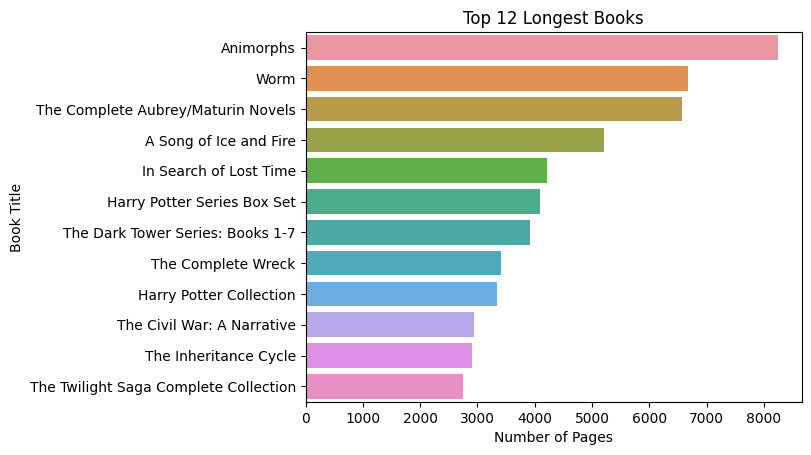

In [283]:
longest_books = df.nlargest(12, 'Number of Pages')

sns.barplot(x = 'Number of Pages', y = 'Title', data = longest_books)
plt.title('Top 12 Longest Books')
plt.xlabel('Number of Pages')
plt.ylabel('Book Title')

plt.show()


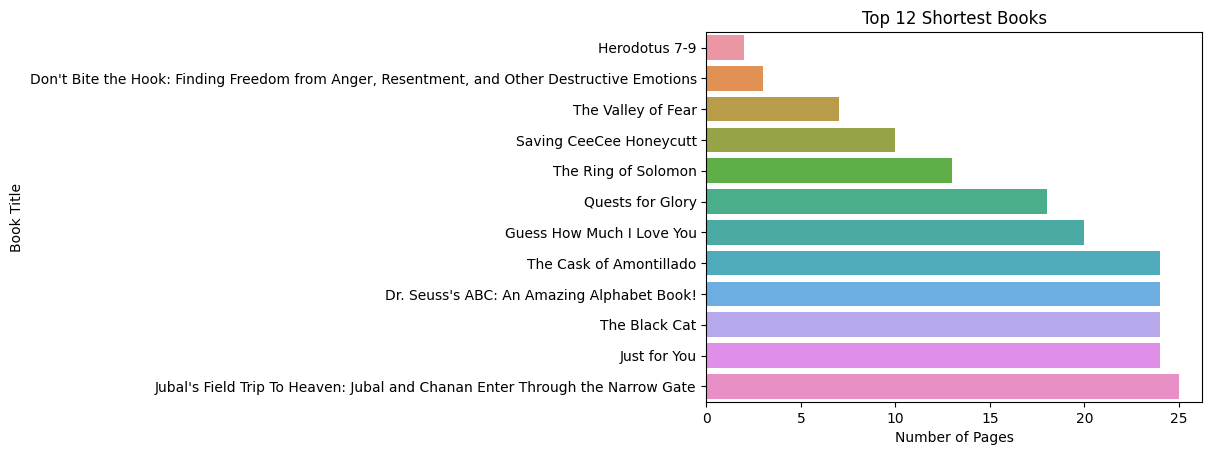

In [284]:
shortest_books = df.nsmallest(12, 'Number of Pages')

sns.barplot(x = 'Number of Pages', y = 'Title', data = shortest_books)
plt.title('Top 12 Shortest Books')
plt.xlabel('Number of Pages')
plt.ylabel('Book Title')

plt.show()

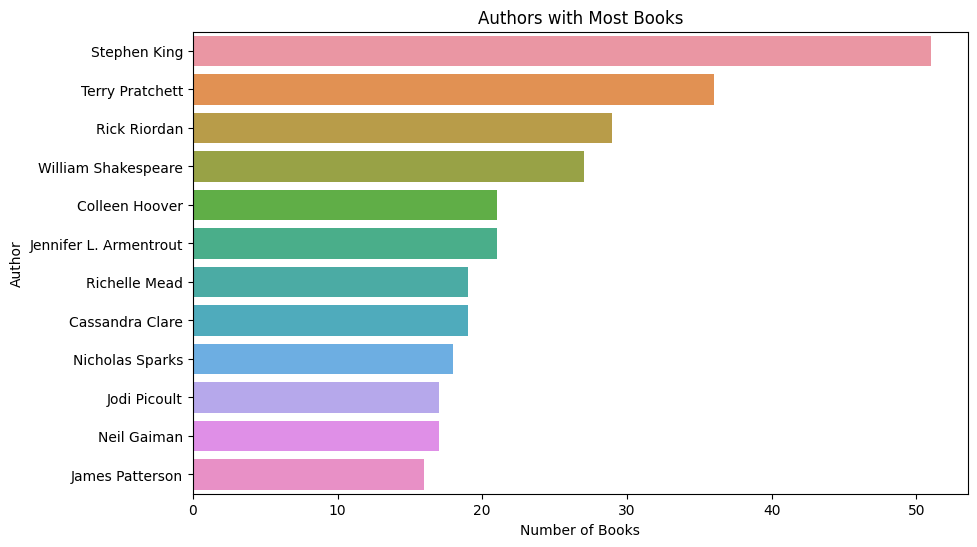

In [285]:
authors_most_books = df['Author'].value_counts().nlargest(12)
plt.figure(figsize=(10, 6))
sns.barplot(x = authors_most_books, y = authors_most_books.index)
plt.title('Authors with Most Books')
plt.xlabel('Number of Books')
plt.ylabel('Author')
plt.show()

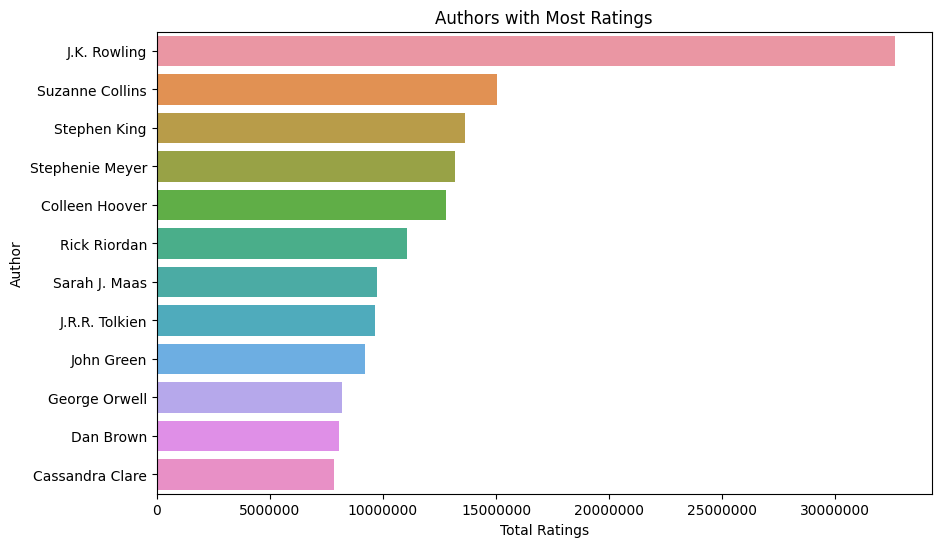

In [286]:
authors_most_ratings = df.groupby('Author')['Number of Ratings'].sum().nlargest(12)
plt.figure(figsize=(10, 6))
sns.barplot(x = authors_most_ratings, y = authors_most_ratings.index)
plt.title('Authors with Most Ratings')
plt.xlabel('Total Ratings')
plt.ylabel('Author')
plt.ticklabel_format(axis='x',style='plain')
plt.show()

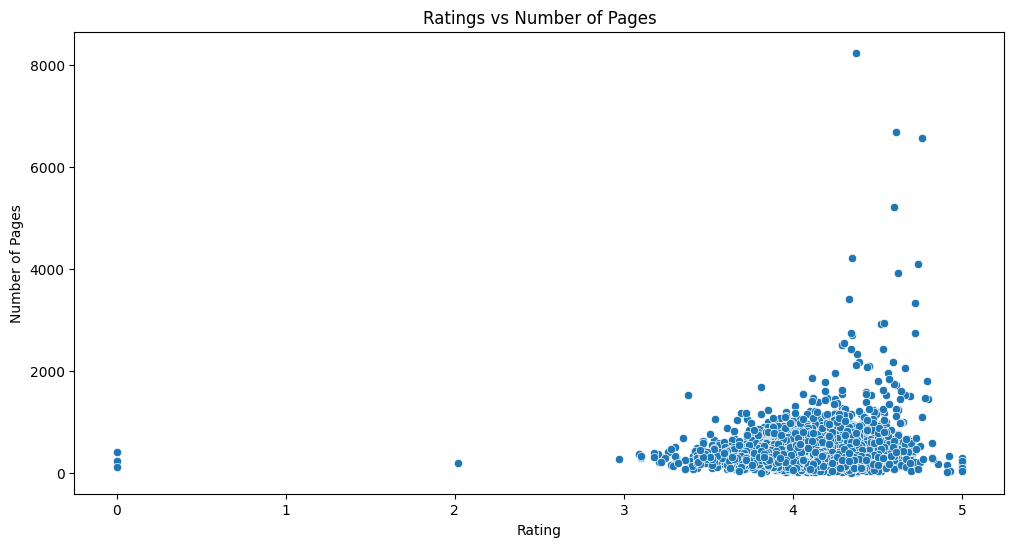

In [287]:
plt.figure(figsize = (12, 6))
sns.scatterplot(x = 'Rating', y = 'Number of Pages', data = df)
plt.title('Ratings vs Number of Pages')
plt.xlabel('Rating')
plt.ylabel('Number of Pages')

plt.show()

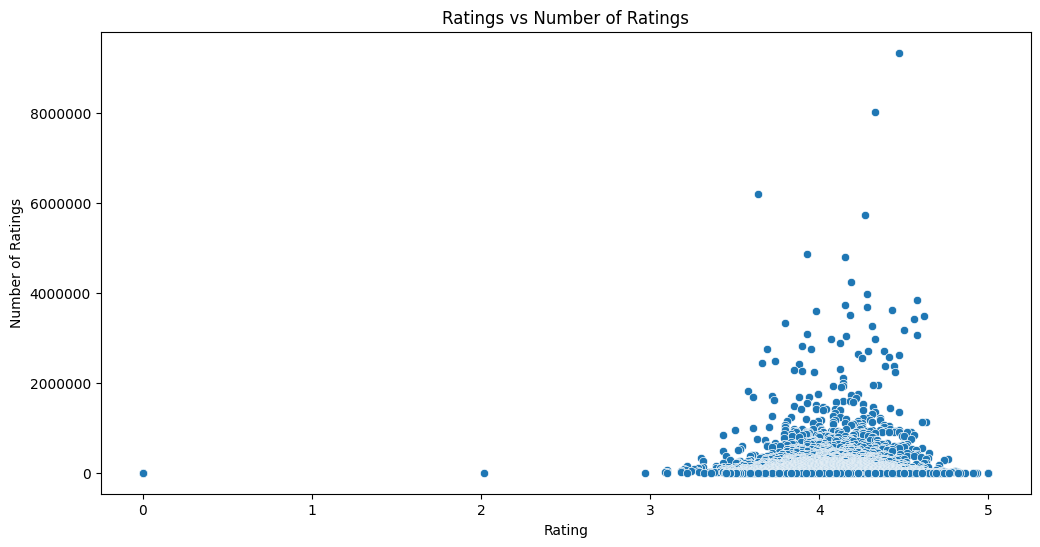

In [288]:
plt.figure(figsize = (12, 6))
sns.scatterplot(x = 'Rating', y = 'Number of Ratings', data = df)
plt.title('Ratings vs Number of Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.ticklabel_format(axis = 'y',style = 'plain')
plt.show()

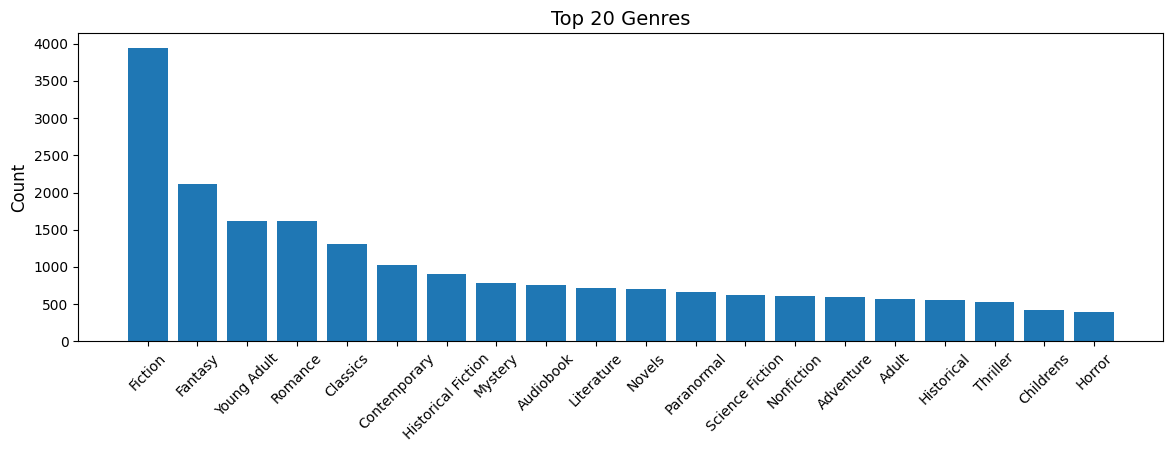

In [312]:
# get top 20 unique items and count
top_values = exploded_genres.nlargest(20).index.tolist()
top_value_counts = exploded_genres.nlargest(20).values

fig, ax = plt.subplots(figsize=(14, 4))
ax.bar(top_values, top_value_counts)
ax.set_ylabel("Count", size=12)
ax.set_title("Top 20 Genres", size=14)
plt.xticks(rotation=45)  

plt.show()

## Outliers

<Axes: xlabel='Number of Pages'>

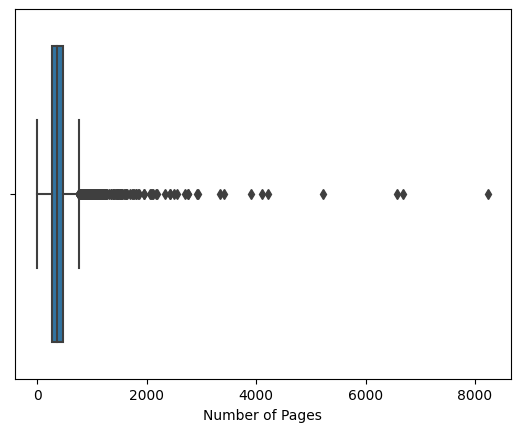

In [292]:
sns.boxplot(x=df['Number of Pages'])

<Axes: xlabel='Number of Pages'>

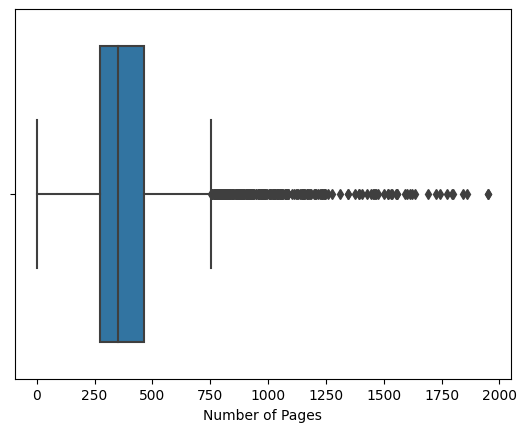

In [516]:
# deleting outliers for books > 2000 pages
df = df[df['Number of Pages'] <= 2000]

sns.boxplot(x=df['Number of Pages'])

<Axes: xlabel='Number of Ratings'>

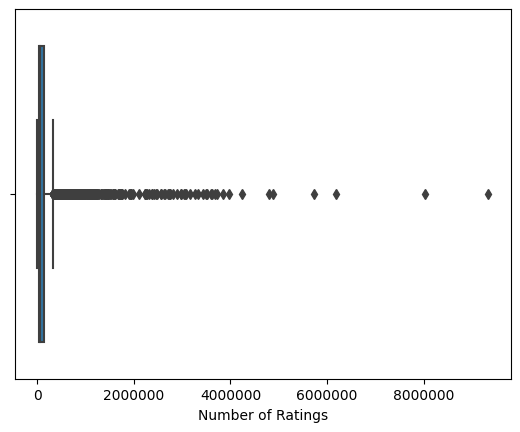

In [517]:
plt.ticklabel_format(axis = 'x', style = 'plain')
sns.boxplot(x = df['Number of Ratings'])

In [296]:
# books with < 100 reviews
no_reviews = df[df['Number of Ratings'] < 100]
count = len(no_reviews)

print(count)

66


<Axes: xlabel='Number of Ratings'>

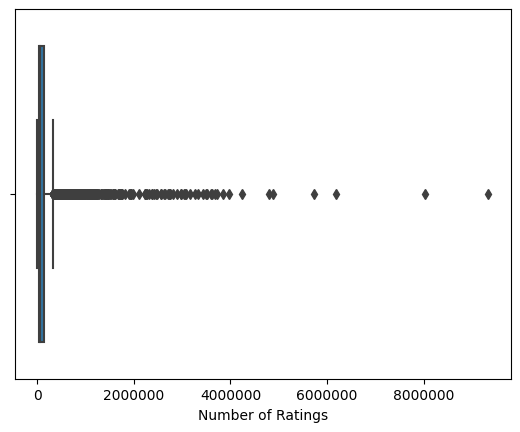

In [298]:
df = df[df['Number of Ratings'] >=100]
plt.ticklabel_format(axis = 'x', style = 'plain')
sns.boxplot(x = df['Number of Ratings'])

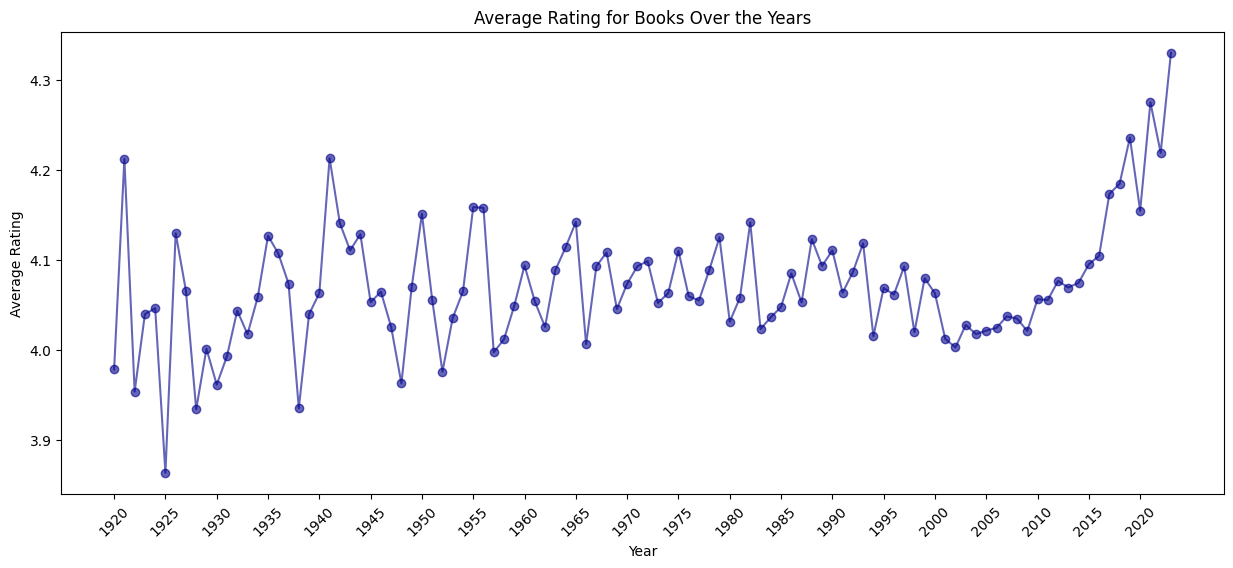

In [299]:
# filtered df from >= 1920
df_filtered = df[df['Year'] >= 1920]

# group by 'Year' 
average_ratings = df_filtered.groupby('Year')['Rating'].mean()

plt.figure(figsize = (15, 6))

plt.plot(average_ratings.index, average_ratings.values, marker='o', linestyle='-', color = 'darkblue', alpha = 0.6)
plt.title('Average Rating for Books Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Rating')

tick_values = range(1920, df_filtered['Year'].max() + 1, 5)
plt.xticks(tick_values)

plt.xticks(rotation=45)
plt.show()


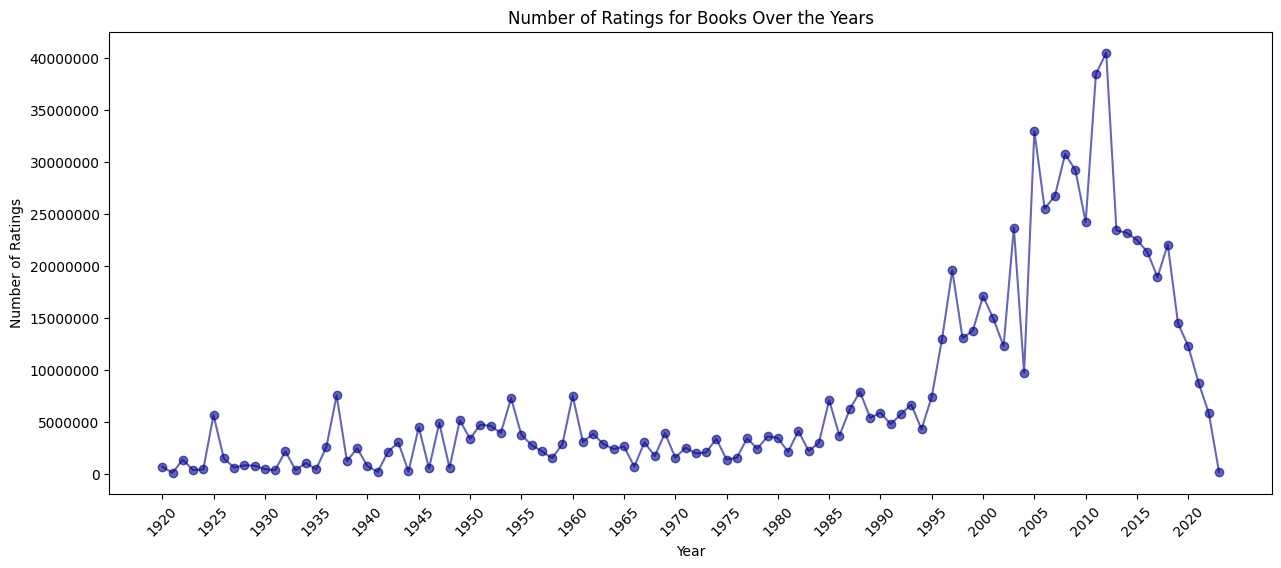

In [519]:
# group by 'Year'
total_ratings = df_filtered.groupby('Year')['Number of Ratings'].sum()

plt.figure(figsize = (15, 6))

plt.plot(total_ratings.index, total_ratings.values, marker='o', linestyle='-', color='darkblue', alpha=0.6)
plt.title('Number of Ratings for Books Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Ratings')

tick_values = range(1920, 2021, 5)
plt.xticks(tick_values)
plt.xticks(rotation=45)
plt.ticklabel_format(axis = 'y', style = 'plain')

plt.show()

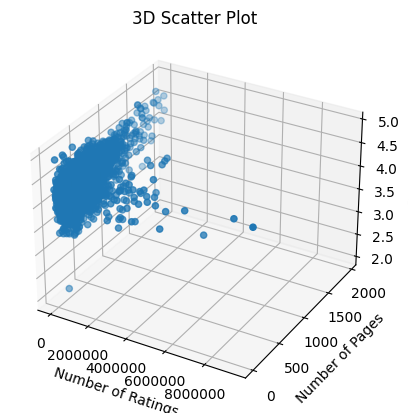

In [520]:
from mpl_toolkits.mplot3d import Axes3D

x = df['Number of Ratings']
y = df['Number of Pages']
z = df['Rating']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)

ax.set_xlabel('Number of Ratings')
ax.set_ylabel('Number of Pages')
ax.set_zlabel('Rating')
ax.set_title('3D Scatter Plot')

plt.ticklabel_format(axis = 'x', style = 'plain')
plt.show()

In [313]:
def boolean_df(item_lists, unique_items):
# empty dictionary
    bool_dict = {}
    
    for i, item in enumerate(unique_items):
        bool_dict[item] = item_lists.apply(lambda x: item in x)
    return pd.DataFrame(bool_dict)

In [328]:
# generate boolean map for each genre and title
genres_bool = boolean_df(
  item_lists = df['Genres'],
  unique_items = unique_genres
)

genres_bool.head()

,Fiction,Fantasy,Young Adult,Romance,Classics,Contemporary,Historical Fiction,Mystery,Audiobook,Literature,...,16th Century,Brain,Urban,Medieval History,Engineering,Seinen,Cycling,Food Writing,Foodie,Bulgarian Literature
0,True,True,True,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,True,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,True,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,True,False,True,False,True,False,True,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,True,False,False,True,True,False,True,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [320]:
genres_corr = genres_bool.corr(method = "pearson")
print(genres_corr)

                      Fiction  Fantasy  Young Adult  Romance  Classics  \
Fiction                  1.00     0.09         0.11    -0.13      0.19   
Fantasy                  0.09     1.00         0.37     0.16     -0.21   
Young Adult              0.11     0.37         1.00     0.30     -0.22   
Romance                 -0.13     0.16         0.30     1.00     -0.26   
Classics                 0.19    -0.21        -0.22    -0.26      1.00   
...                       ...      ...          ...      ...       ...   
Seinen                   0.01     0.02        -0.01    -0.01     -0.01   
Cycling                 -0.03    -0.01        -0.01    -0.01     -0.01   
Food Writing            -0.03    -0.01        -0.01    -0.01     -0.01   
Foodie                  -0.03    -0.01        -0.01    -0.01     -0.01   
Bulgarian Literature    -0.03     0.02        -0.01    -0.01     -0.01   

                      Contemporary  Historical Fiction  Mystery  Audiobook  \
Fiction                       0.1

In [627]:
genres_int = genres_bool.astype(int)
genres_freq_mat = np.dot(genres_int.T, genres_int)

genres_freq = pd.DataFrame(
    genres_freq_mat,
    columns = unique_genres,
    index = unique_genres
)

genres_freq

,Fiction,Fantasy,Young Adult,Romance,Classics,Contemporary,Historical Fiction,Mystery,Audiobook,Literature,...,16th Century,Brain,Urban,Medieval History,Engineering,Seinen,Cycling,Food Writing,Foodie,Bulgarian Literature
Fiction,3942,1721,1355,1109,1178,869,891,745,599,703,...,1,0,1,0,0,1,0,0,0,0
Fantasy,1721,2110,1100,846,307,86,195,221,271,79,...,0,0,0,0,0,1,0,0,0,1
Young Adult,1355,1100,1623,843,187,368,172,167,154,26,...,0,0,1,0,0,0,0,0,0,0
Romance,1109,846,843,1611,141,531,253,137,166,75,...,0,0,0,0,0,0,0,0,0,0
Classics,1178,307,187,141,1304,74,396,110,62,590,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Seinen,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
Cycling,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
Food Writing,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
Foodie,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


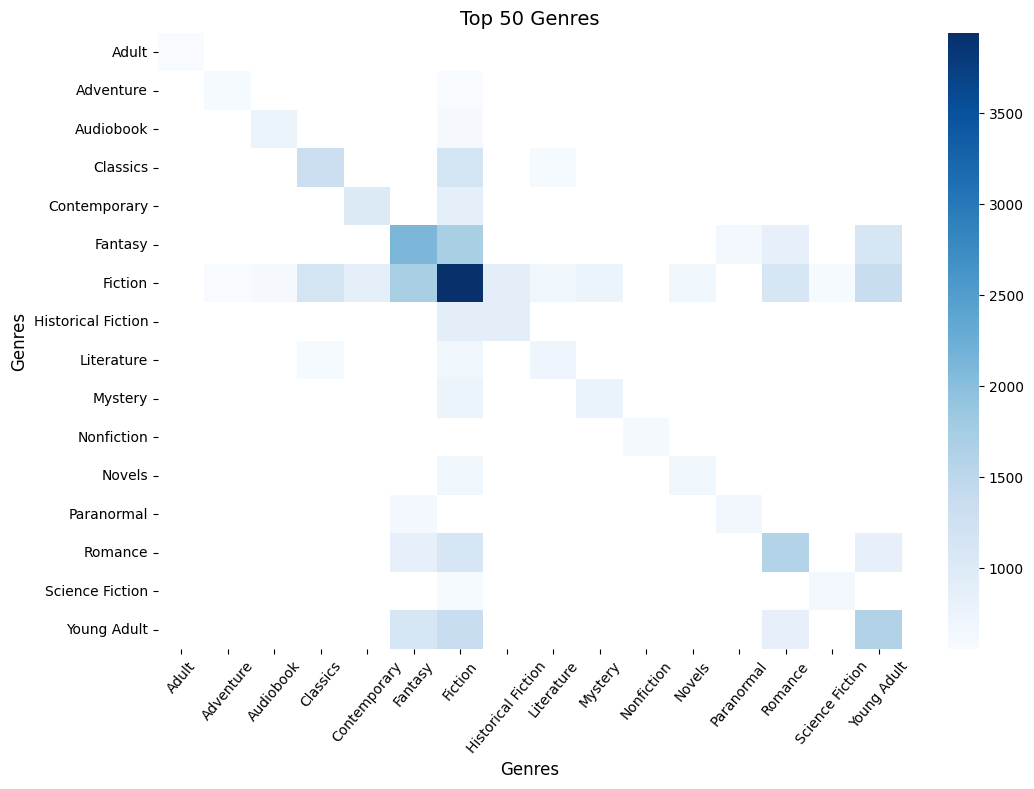

In [327]:
import seaborn as sns

top_50_genres = genres_freq.stack().nlargest(50)

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(top_50_genres.unstack(), cmap="Blues")
plt.xticks(rotation=50)
plt.title('Top 50 Genres', fontsize=14)
plt.xlabel('Genres', fontsize=12)
plt.ylabel('Genres', fontsize=12)
plt.show()

In [342]:
# original df with each genre as a column
df_merged = pd.concat([df, genres_int], axis=1)

In [329]:
# label encoding for author
le = preprocessing.LabelEncoder()
df_merged['Author_Encoded'] = le.fit_transform(df_merged['Author'])

In [349]:
missing_values = df_merged.isnull().sum()
print(missing_values)

Title                   20
Author                  20
Year                    20
Rating                  20
Number of Ratings       20
                        ..
Seinen                   0
Cycling                  0
Food Writing             0
Foodie                   0
Bulgarian Literature     0
Length: 458, dtype: int64


In [350]:
df_merged = df_merged.dropna()

In [588]:
numm_ratings = df_filtered.groupby('Year')['Number of Ratings'].sum()

## Random Forest Model

In [535]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# removing unnecessary variables and treating the rest as independent variables
X = df_merged.drop(['Rating', 'Author', 'Title', 'Genres'], axis = 1)  
# dependant variable
y = df_merged['Rating'] 

# random forest regressor
rf = RandomForestRegressor(random_state = 42)
rf.fit(X, y)

# getting the most important independent variables
importance = rf.feature_importances_

important_var = pd.DataFrame({'Feature': X.columns, 'Importance': importance})

# sorting
sorted_features = important_var.sort_values('Importance', ascending = False)
sorted_features['Importance'] = sorted_features['Importance'].apply(lambda x: f'{x:.2f}')

# top 10 variables
top_n = 10
print(sorted_features.head(top_n))


              Feature Importance
2     Number of Pages       0.15
1   Number of Ratings       0.13
0                Year       0.13
3      Author_Encoded       0.09
84             Comics       0.02
9        Contemporary       0.01
4             Fiction       0.01
14             Novels       0.01
23             Horror       0.01
18          Adventure       0.01


/var/folders/9x/yx1lb15s25v5pjcj6fv0mdrc0000gn/T/ipykernel_14038/2610783610.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



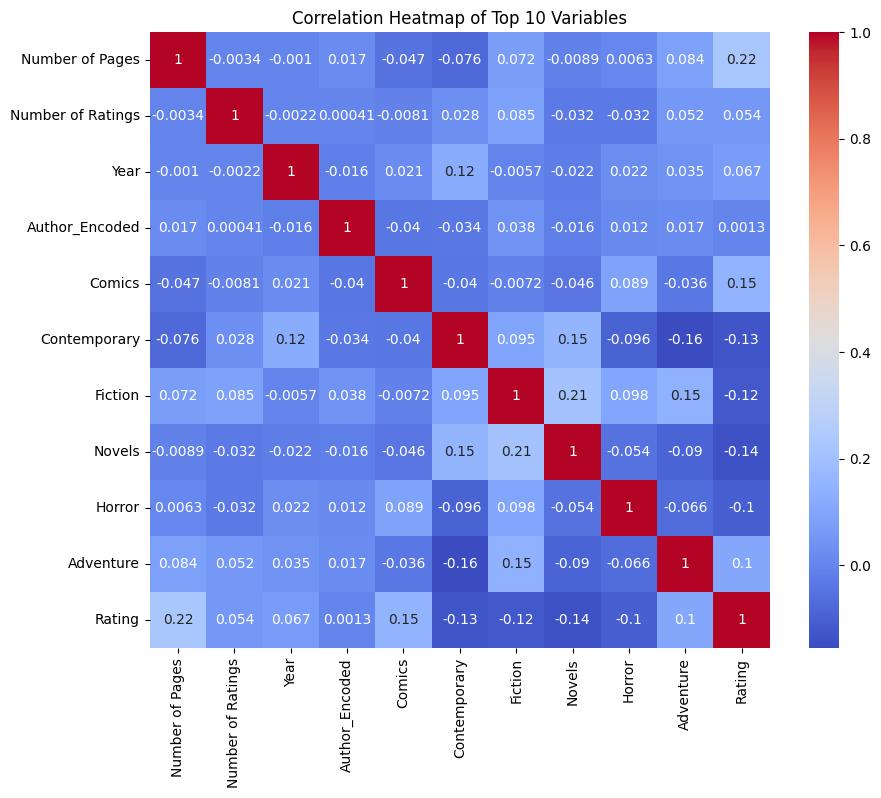

In [546]:
top_features = sorted_features['Feature'].head(top_n).tolist()
top_df = X[top_features]

top_df['Rating'] = y

correlation_matrix = top_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

plt.title('Correlation Heatmap of Top 10 Variables')
plt.show()

In [621]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# deleting all columns except top N
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# train model
rf_top = RandomForestRegressor(random_state=42)
rf_top.fit(X_train_top, y_train)

# predict test records
y_pred_rf = rf_top.predict(X_test_top)

# model evaluation
mse_top_rf = mean_squared_error(y_test, y_pred_rf)
mae_top_rf = mean_absolute_error(y_test, y_pred_rf)
r2_top_rf = r2_score(y_test, y_pred_rf)

print("Mean Squared Error (MSE):", mse_top_rf)
print("Mean Absolute Error (MAE):", mae_top_rf)
print("R-squared (R2):", r2_top_rf)

# score for training and test model
train_score_rf = rf_top.score(X_train_top, y_train)
test_score_rf = rf_top.score(X_test_top, y_test)
print("Model Score:", test_score_rf)

Mean Squared Error (MSE): 0.043034676679725735
Mean Absolute Error (MAE): 0.16082967678746318
R-squared (R2): 0.21301770989964286
Model Score: 0.21301770989964286


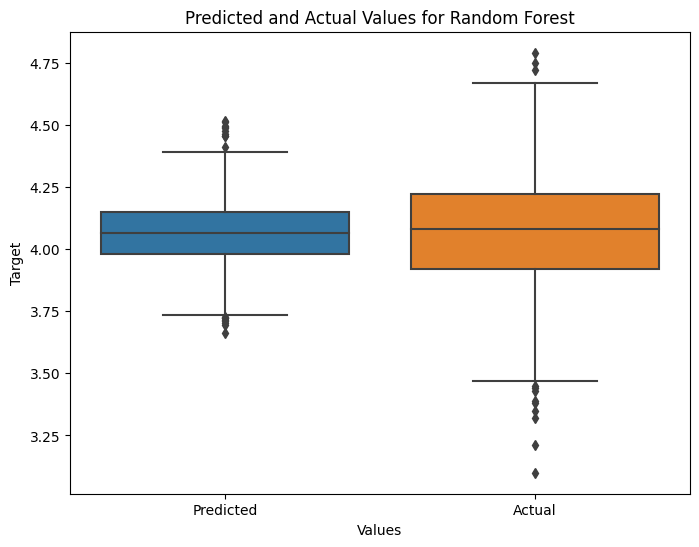

In [573]:
rf_results_df = pd.DataFrame({'Predicted': y_pred_rf, 'Actual': y_test})

plt.figure(figsize=(8, 6))
sns.boxplot(data=rf_results_df)

plt.title('Predicted and Actual Values for Random Forest')
plt.xlabel('Values')
plt.ylabel('Target')

plt.show()


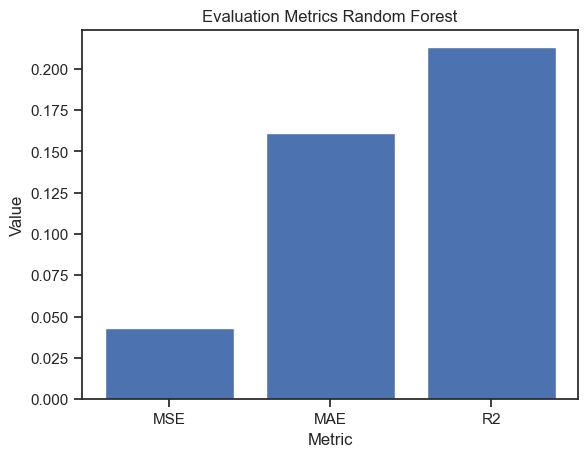

In [623]:
metrics_rf = ['MSE', 'MAE', 'R2']
values_rf = [mse_top_rf, mae_top_rf, r2_top_rf]

plt.bar(metrics_rf, values_rf)
plt.title('Evaluation Metrics Random Forest')
plt.xlabel('Metric')
plt.ylabel('Value')

plt.show()

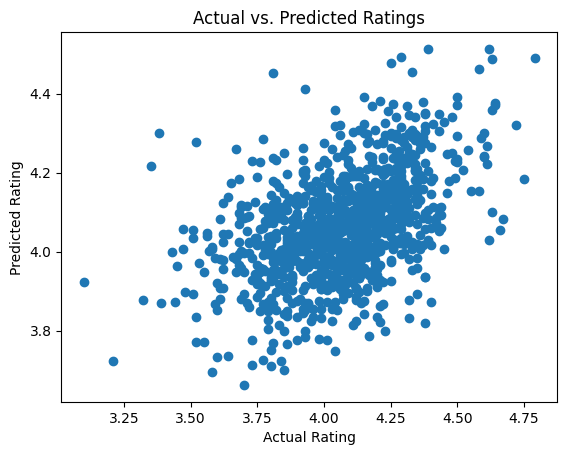

In [563]:
plt.scatter(y_test, y_pred_rf)
plt.title('Actual vs. Predicted Ratings')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')

plt.show()


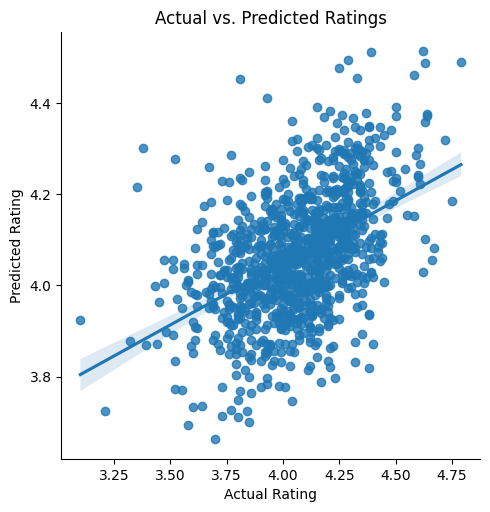

In [577]:
sns.lmplot(x='Actual', y='Predicted', data=rf_results_df)
plt.title('Actual vs. Predicted Ratings')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')

plt.show()

## Margin of Error

In [598]:
margin_of_error = 0.2

lower_bound = y_test - margin_of_error
upper_bound = y_test + margin_of_error

within_range = ((y_pred_rf >= lower_bound) & (y_pred_rf <= upper_bound)).sum()

accuracy_error_rf = within_range / len(y_test) 

print("Accuracy within the margin of error:", accuracy_error_rf)

Accuracy within the margin of error: 0.6993143976493633


In [590]:
print(rf_results_df)

      Predicted  Actual
4163       3.90    4.01
586        4.10    3.99
553        4.09    4.21
227        4.04    3.96
1323       4.04    3.99
...         ...     ...
4049       3.99    4.16
1435       3.91    3.99
1019       3.99    4.14
582        3.95    3.70
203        4.00    4.07

[1021 rows x 2 columns]


## Linear Regression Model

In [593]:
from sklearn.linear_model import LinearRegression

# train model
lr_top = LinearRegression()
lr_top.fit(X_train_top, y_train)

y_pred_lr = lr_top.predict(X_test_top)

# model evaluation
mse_top_lr = mean_squared_error(y_test, y_pred_lr)
mae_top_lr = mean_absolute_error(y_test, y_pred_lr)
r2_top_lr = r2_score(y_test, y_pred_lr)

print("Mean Squared Error (MSE):", mse_top_lr)
print("Mean Absolute Error (MAE):", mae_top_lr)
print("R-squared (R2):", r2_top_lr)

# training and test score
train_score_lr = lr_top.score(X_train_top, y_train)
test_score_lr = lr_top.score(X_test_top, y_test)
print("Model Score:", test_score_lr)

Mean Squared Error (MSE): 0.05043158196454964
Mean Absolute Error (MAE): 0.17710880644513605
R-squared (R2): 0.07774927268030107
Model Score: 0.07774927268030107


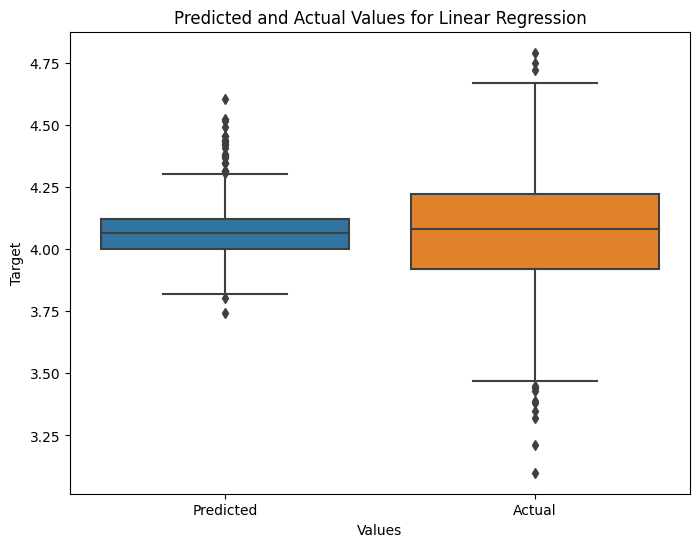

In [572]:
lr_results_df = pd.DataFrame({'Predicted': y_pred_lr, 'Actual': y_test})

plt.figure(figsize=(8, 6))
sns.boxplot(data=lr_results_df)

plt.title('Predicted and Actual Values for Linear Regression')
plt.xlabel('Values')
plt.ylabel('Target')

plt.show()

## Margin of Error

In [622]:
within_range = ((y_pred_lr >= lower_bound) & (y_pred_lr <= upper_bound)).sum()

accuracy_error_lr = within_range / len(y_test) 

print("Accuracy within the margin of error:", accuracy_error_lr)

Accuracy within the margin of error: 0.6425073457394711


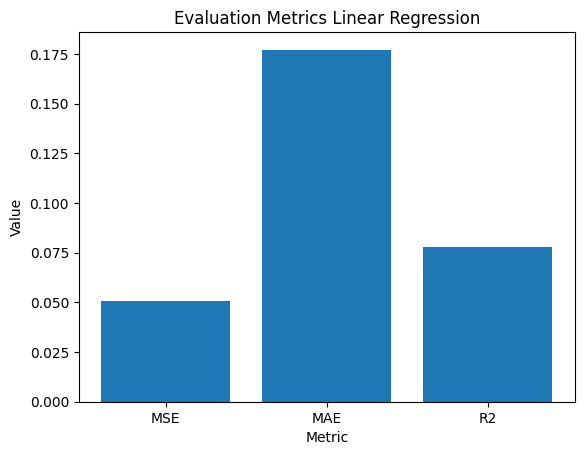

In [582]:
metrics_lr = ['MSE', 'MAE', 'R2']
values_lr = [mse_top_lr, mae_top_lr, r2_top_lr]

plt.bar(metrics_lr, values_lr)
plt.title('Evaluation Metrics Linear Regression')
plt.xlabel('Metric')
plt.ylabel('Value')

plt.show()


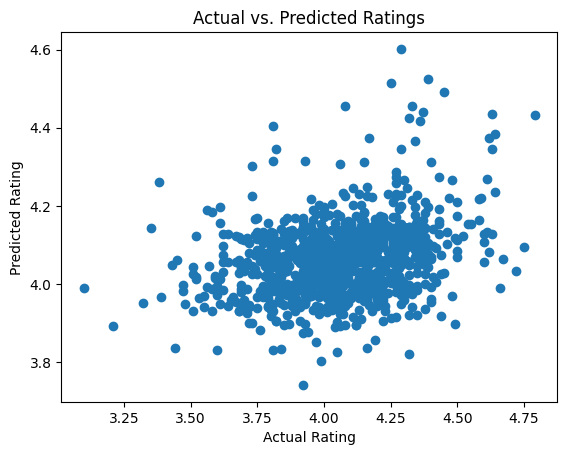

In [576]:
plt.scatter(y_test, y_pred_lr)
plt.title('Actual vs. Predicted Ratings')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')

plt.show()


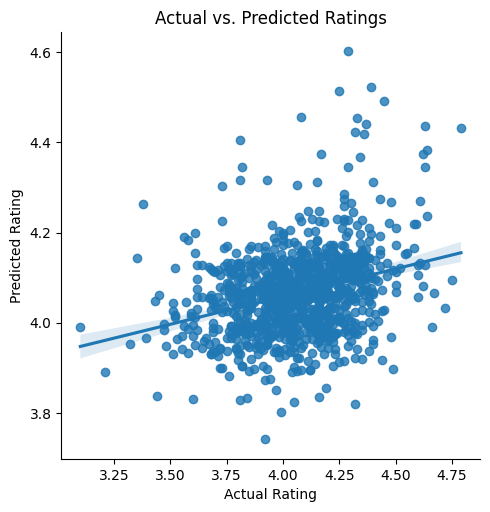

In [586]:
lr_results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_lr})

sns.lmplot(x='Actual', y='Predicted', data=lr_results_df)
plt.title('Actual vs. Predicted Ratings')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')

plt.show()


## Comparison of Scores

In [619]:
scores_df = pd.DataFrame({
    'Model': ['Random Forest', 'Linear Regression'],
    'Train Score': [train_score_rf, train_score_lr],
    'Test Score': [test_score_rf, test_score_lr],
    'Score with Margin of Error': [accuracy_error_rf, accuracy_error_lr]
})

scores_df.iloc[:, 1:]= scores_df.iloc[:, 1:].applymap(lambda x: f'{x*100:.2f}%')

score_data = scores_df
score_columns = [{'name': col, 'id': col} for col in score_data.columns]

scores_df

,Model,Train Score,Test Score,Score with Margin of Error
0,Random Forest,89.92%,21.30%,69.93%
1,Linear Regression,15.43%,7.77%,64.25%


## Dash

In [587]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import dash_table
import plotly.graph_objs as go

trace_rf = go.Bar(
    x=metrics_rf,
    y=values_rf,
    name='Random Forest'
)

trace_lr = go.Bar(
    x=metrics_lr,
    y=values_lr,
    name='Linear Regression'
)

layout = go.Layout(
    title='Evaluation Metrics',
    xaxis=dict(title='Metric'),
    yaxis=dict(title='Value'),
    barmode='group'
)
figure = go.Figure(data=[trace_rf, trace_lr], layout=layout)

In [626]:
df_top20 = df.head(20)
df_top20['Genres'] = df_top20['Genres'].apply(lambda x: ', '.join(x))

table_data = df_top20.to_dict('records')
table_columns = [{'name': col, 'id': col} for col in df_top20.columns]

rating_counts = df['Rating'].value_counts().head(20)

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1(children="Goodreads Data", style={'font-family': 'Arial, sans-serif'}),
    html.H2(children="Dataset (Top 20 Rows):", style={'font-family': 'Arial, sans-serif'}),

    dash_table.DataTable(
        data=table_data,
        columns=table_columns,
        style_table={'overflowX': 'auto'},
        style_header={'backgroundColor': 'rgb(230, 230, 230)', 'fontWeight': 'bold'},
        style_cell={'textAlign': 'center'}
    ),
    html.H2(children="Data Exploratory Analysis:", style={'font-family': 'Arial, sans-serif'}),
    
    dcc.Graph(
        figure={
            'data': [
                {
                    'x': df['Rating'].value_counts().head(20).index,
                    'y': df['Rating'].value_counts().head(20).values,
                    'type': 'bar',
                    'marker': {'color': 'blue'}
                }
            ],
            'layout': {
                'title': 'Number of Books For Each Rating',
                'xaxis': {
                    'title': 'Ratings',
                    'tickmode': 'array',
                    'tickvals': df['Rating'].value_counts().head(20).index,
                    'ticktext': df['Rating'].value_counts().head(20).index.map(str)
                },
                'yaxis': {'title': 'Number of Books'},
                'margin': {'l': 50, 'r': 50, 't': 50, 'b': 50},
                'showlegend': False
            }
        }
    ),
    dcc.Graph(
        figure={
            'data': [
                go.Bar(
                    x=popular_books['Number of Ratings'],
                    y=popular_books['Title'],
                    orientation='h',
                    marker={'color': 'blue'}
                )
            ],
            'layout': {
                'title': 'Top 15 Highest Rated Books',
                'xaxis': {'title': 'Ratings Count'},
                'yaxis': {'title': 'Book Title', 'automargin': True, 'autorange':'reversed'},
                'bargap': 0.1,
                'height': 600,
                'margin': {'l': 150}
            }
        }
    ),
    dcc.Graph(
        figure={
            'data': [
                go.Bar(
                    x=longest_books['Number of Pages'],
                    y=longest_books['Title'],
                    orientation='h',
                    marker={'color': 'blue'}
                )
            ],
            'layout': {
                'title': 'Top 12 Longest Books',
                'xaxis': {'title': 'Number of Pages'},
                'yaxis': {'title': 'Book Title', 'automargin': True, 'autorange':'reversed'},
                'bargap': 0.1,
                'height': 600,
                'margin': {'l': 150}
            }
        }
    ),
    dcc.Graph(
        figure={
            'data': [
                go.Bar(
                    x=shortest_books['Number of Pages'],
                    y=shortest_books['Title'],
                    orientation='h',
                    marker={'color': 'blue'}
                )
            ],
            'layout': {
                'title': 'Top 12 Shortest Books',
                'xaxis': {'title': 'Number of Pages'},
                'yaxis': {'title': 'Book Title', 'automargin': True},
                'bargap': 0.1,
                'height': 600,
                'margin': {'l': 150}
            }
        }
    ),
    dcc.Graph(
        figure={
            'data': [
                go.Bar(
                    x=authors_most_books,
                    y=authors_most_books.index,
                    orientation='h',
                    marker={'color': 'blue'}
                )
            ],
            'layout': {
                'title': 'Authors With Most Books',
                'xaxis': {'title': 'Number of Books'},
                'yaxis': {'title': 'Author', 'automargin': True, 'autorange':'reversed'},
                'bargap': 0.1,
                'height': 600,
                'margin': {'l': 150}
            }
        }
    ),
    dcc.Graph(
        figure={
            'data': [
                go.Bar(
                    x=authors_most_ratings,
                    y=authors_most_ratings.index,
                    orientation='h',
                    marker={'color': 'blue'}
                )
            ],
            'layout': {
                'title': 'Authors with Most Ratings',
                'xaxis': {'title': 'Number of Ratings'},
                'yaxis': {'title': 'Author', 'automargin': True, 'autorange':'reversed'},
                'bargap': 0.1,
                'height': 600,
                'margin': {'l': 150}
            }
        }
    ),
    dcc.Graph(
        figure={
            'data': [
                go.Scatter(
                    x=df['Rating'],
                    y=df['Number of Pages'],
                    mode='markers',
                    marker={
                        'size': 8,
                        'color': df['Rating'],
                        'colorscale': 'Viridis',
                        'showscale': True,
                        'colorbar': {'title': 'Rating'},
                    },
                )
            ],
            'layout': {
                'title': 'Ratings vs Number of Pages',
                'xaxis': {'title': 'Rating'},
                'yaxis': {'title': 'Number of Pages'},
                'height': 600,
                'margin': {'l': 100, 'r': 100, 't': 100, 'b': 100},
            }
        }
    ),
    dcc.Graph(
        figure={
            'data': [
                go.Scatter(
                    x=df['Rating'],
                    y=df['Number of Ratings'],
                    mode='markers',
                    marker={
                        'size': 8,
                        'color': df['Rating'],
                        'colorscale': 'Viridis',
                        'showscale': True,
                        'colorbar': {'title': 'Rating'},
                    },
                )
            ],
            'layout': {
                'title': 'Ratings vs Number of Ratings',
                'xaxis': {'title': 'Rating'},
                'yaxis': {'title': 'Number of Ratings'},
                'height': 600,
                'margin': {'l': 100, 'r': 100, 't': 100, 'b': 100},
            }
        }
    ),
    dcc.Graph(
        figure={
            'data': [
                {
                    'x': df['Rating'],
                    'type': 'histogram',
                    'name': 'Rating',
                    'marker': {'color': 'blue'}
                }
            ],
            'layout': {
                'title': 'Rating Distribution',
                'xaxis': {'title': 'Rating'},
                'yaxis': {'title': 'Frequency'}
            }
        }
    ),
    dcc.Graph(
        figure={
            'data': [
                go.Bar(
                    x=top_value_counts,
                    y=top_values,
                    orientation='h',
                    marker={'color': 'blue'}
                )
            ],
            'layout': {
                'title': 'Top 20 Genres',
                'xaxis': {'title': 'Count'},
                'yaxis': {'title': 'Genre', 'automargin': True, 'autorange':'reversed'},
                'bargap': 0.1,
                'height': 600,
                'margin': {'l': 150}
            }
        }
    ),
    dcc.Graph(
        figure={
            'data': [
                go.Scatter(
                    x=average_ratings.index,
                    y=average_ratings.values,
                    mode='lines',
                    marker=dict(color=average_ratings.values, colorscale=color_scale, showscale=True),
                    name='Average Rating'
                )
            ],
            'layout': {
                'title': 'Average Rating for Books Over the Years',
                'xaxis': {'title': 'Year'},
                'yaxis': {'title': 'Average Rating'}
            }
        }
    ),
    dcc.Graph(
        figure={
            'data': [
                go.Scatter(
                    x=numm_ratings.index,
                    y=numm_ratings.values,
                    mode='lines',
                    marker=dict(color='darkblue'),
                    name='Number of Ratings'
                )
            ],
            'layout': {
                'title': 'Number of Ratings Over the Years',
                'xaxis': {'title': 'Year'},
                'yaxis': {'title': 'Number of Ratings'}
            }
        }
    ),
    dcc.Graph(
        figure={
            'data': [
                go.Scatter3d(
                    x=df_merged['Number of Ratings'],
                    y=df_merged['Number of Pages'],
                    z=df_merged['Rating'],
                    mode='markers',
                    marker=dict(
                        size=5,
                        color=df_merged['Rating'],
                        colorscale='Viridis',
                        opacity=0.8
                    ),
                    name='Scatter Plot'
                )
            ],
            'layout': {
                'title': '3D Scatter Plot',
                'scene': {
                    'xaxis': {'title': 'Number of Ratings'},
                    'yaxis': {'title': 'Number of Pages'},
                    'zaxis': {'title': 'Rating'}
                },
                'plot_bgcolor': '#F8F8F8',  
                'paper_bgcolor': '#F8F8F8'  
            }
        }
    ),
    html.H2("Top 10 Features", style={'font-family': 'Arial, sans-serif', "text-align": "center"}),
        dash_table.DataTable(
            id="table",
            columns=[{"name": col, "id": col} for col in sorted_features.columns],
            data=sorted_features.head(top_n).to_dict("records"),
            style_cell={"textAlign": "center"},
        ),
    dcc.Graph(
        figure={
            'data': [
                go.Heatmap(
                    x = correlation_matrix.columns,
                    y = correlation_matrix.index,
                    z = np.array(correlation_matrix),
                    text=np.around(z, decimals=2),
                    texttemplate="%{text}" 
                )
            ],
            'layout': {
                'title': 'Correlation Matrix',
                'margin': {'l': 150, 'r': 50, 't': 50, 'b': 100}
            }        
        }
    ),
    html.H2("Random Forest Results", style={'font-family': 'Arial, sans-serif', "text-align": "center"}),
    dcc.Graph(
            id='box-plots',
            figure={
                'data': [
                    {'y': rf_results_df['Predicted'], 'type': 'box', 'name': 'Predicted'},
                    {'y': rf_results_df['Actual'], 'type': 'box', 'name': 'Actual'}
                ],
                'layout': {
                    'title': 'Predicted and Actual Values',
                    'xaxis': {'title': 'Values'},
                    'yaxis': {'title': 'Target'},
                    'width': 800,  
                    'margin': {'l': 50, 'r': 50, 't': 50, 'b': 50} 
                }
            }
    ),
    html.H2("Linear Regression Results", style={'font-family': 'Arial, sans-serif', "text-align": "center"}),
    dcc.Graph(
            id='box-plots-lr',
            figure={
                'data': [
                    {'y': lr_results_df['Predicted'], 'type': 'box', 'name': 'Predicted'},
                    {'y': lr_results_df['Actual'], 'type': 'box', 'name': 'Actual'}
                ],
                'layout': {
                    'title': 'Predicted and Actual Values',
                    'xaxis': {'title': 'Values'},
                    'yaxis': {'title': 'Target'},
                    'width': 800,  
                    'margin': {'l': 50, 'r': 50, 't': 50, 'b': 50}  
                }
            }
    ),
    html.H2("Comparison", style={'font-family': 'Arial, sans-serif', "text-align": "center"}),
    dash_table.DataTable(
        data=score_data.to_dict('records'),
        columns=score_columns,
        style_table={'overflowX': 'auto'},
        style_header={'backgroundColor': 'rgb(230, 230, 230)', 'fontWeight': 'bold'},
        style_cell={'textAlign': 'center'}
    ),
    dcc.Graph(
            id='evaluation-metrics-graph', 
            figure=figure
    )
])


if __name__ == '__main__':
    app.run_server(host="localhost", debug=True, use_reloader=False, port = 8050)


Dash is running on http://localhost:8050/

 * Serving Flask app '__main__'
 * Debug mode: on


/var/folders/9x/yx1lb15s25v5pjcj6fv0mdrc0000gn/T/ipykernel_14038/3526851946.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

